In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from pydantic import BaseModel, Field
from typing import Optional, List, Any, Literal
from langchain_core.language_models.llms import LLM
from openai import OpenAI
import operator
import json

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LightningLLM(LLM):
    def __init__(self, api_key: str, model: str, **kwargs):
        super().__init__(**kwargs)
        object.__setattr__(self, "client", OpenAI(base_url="https://lightning.ai/api/v1/", api_key=api_key))
        object.__setattr__(self, "model", model)

    def _call(self, prompt: str, stop: Optional[List[str]] = None, run_manager: Optional = None, **kwargs: Any) -> str:
        
        resp = self.client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": [{"type": "text", "text": prompt}]}],
            temperature=0.1,
            max_tokens=2048 
        )
        return resp.choices[0].message.content

    def with_structured_output(self, schema: type[BaseModel]):
        def structured_call(user_input: str):
            schema_json = json.dumps(schema.model_json_schema(), indent=2)
            
            system_instruction = f"""
            You MUST output only valid JSON that strictly matches this schema:
            {schema_json}
            Rules:
            - Do NOT add explanations.
            - Do NOT add additional fields.
            - Output ONLY JSON.
            """
            
            full_prompt = f"{system_instruction}\nUser Query:\n{user_input}"
            raw_output = self._call(full_prompt)
            
            try:
                data = json.loads(raw_output)
            except:
                try:
                    json_part = raw_output[raw_output.find("{"):raw_output.rfind("}") + 1]
                    data = json.loads(json_part)
                except Exception as e:
                    raise ValueError(f"Model did not return valid JSON:\n{raw_output}") from e

            return schema(**data)
        return structured_call
    
    @property
    def _identifying_params(self):
        return {"model": self.model}

    @property
    def _llm_type(self):
        return "lightning_gpt"

In [ ]:
model = LightningLLM(api_key="API_KEY", model="google/gemini-2.5-flash")

In [4]:
class SentimentSchema(BaseModel):
    sentiment : Literal["positive", "negetive"] = Field(description='Sentiment of the review')

In [25]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be') 

In [26]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [17]:
prompt = "What is the sentiment of the following review - the software is good"
structured_model(prompt).sentiment

'positive'

In [18]:
class ReviewState(TypedDict):
    review : str
    sentiment : Literal["positive", "negetive"]
    diagnosis : dict
    response : str

In [27]:
def find_sentiment(state : ReviewState):
    prompt = f'For the following review find out the sentiment \n {state['review']}'
    output = structured_model(prompt).sentiment
    return {'sentiment' : output}

def positive_response(state : ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""
    output = model.invoke(prompt)
    return {'response' : output}

def run_diagonsis(state : ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """
    output = structured_model2(prompt)
    return {'diagnosis' : output.model_dump()}

def negetive_response(state : ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
            The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
            Write an empathetic, helpful resolution message.
            """
    output = model.invoke(prompt)
    return {'response' : output}

In [28]:
def check_sentiment(state : ReviewState) -> Literal['positive_response', 'run_diagonsis']:
    if state['sentiment'] == "positive":
        return 'positive_response'
    else:
        return 'run_diagonsis'

In [29]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagonsis', run_diagonsis)
graph.add_node('negetive_response', negetive_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagonsis', 'negetive_response')
graph.add_edge('negetive_response', END)

workflow = graph.compile()

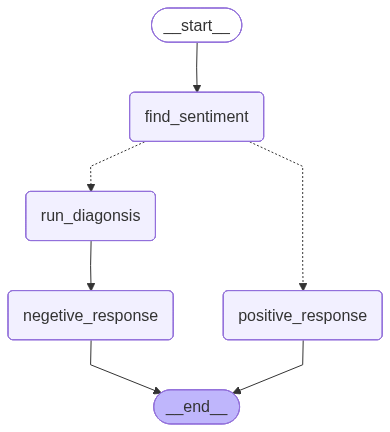

In [30]:
workflow

In [33]:
workflow.invoke({'review' : 'I use this software for a long time. This is really good'})

{'review': 'I use this software for a long time. This is really good',
 'sentiment': 'positive',
 'response': 'That\'s wonderful feedback! Here\'s a warm thank-you message for your user:\n\n---\n\nThank you so much for your incredibly kind review! It truly means a lot to hear that you\'ve been a long-time user of our software and find it "really good." Your continued support and positive feedback are what keep us going!\n\nSince you\'re so familiar with our software, your insights are incredibly valuable. We would be incredibly grateful if you could take a moment to share your thoughts on our official website as well. It helps us improve and also helps other potential users understand the benefits.\n\nThanks again for your wonderful support!'}